## Part 3 - Towing planes

We now relax the assumption that a turn is only assigned to one gate for the whole duration of its stay. If the airport is particularly busy and gates are in short supply it can be the case that a plane arrives at gate A1, is then towed to a 'rest' area, and just before departure is towed back to A1 or perhaps another gate.

We can thus define a tow as the condition that:

`NOT(x[t1_p1, gate] == x[t1_p2, gate]) OR
NOT(x[t1_p2, gate] == x[t1_p3, gate]) for any gate`

That means that if we have a turn with an original turn-id of (for example) 33, and we split this into three turns called turn-97, turn-98, turn-99, we can create a tow-variable `(w)` (similar to the allocation-variable: `x`) that will allow a tow if it's equal to 1, otherwise 0.

The idea is that this variable let's us directly control whether we allow a tow or not and can be endogenous to the optimiser (perhaps with a high cost in the objective to discourage tows)

`tow_turns = [97, 98, 99]`

`
for stand in all_stands:
    prob += x[tow_turns[0], stand] - x[tow_turns[1], stand] <= w[tow_turns[0]]
    prob += x[tow_turns[1], stand] - x[tow_turns[2], stand] <= w[tow_turns[1]]
`

Focusing just on the tow-out (and noting that tow-in will have the same logic):

`prob += x[tow_turns[0], stand] - x[tow_turns[1], stand] <= w[tow_turns[0]]`

We see that we don't need to also include:

`prob += -x[tow_turns[0], stand] + x[tow_turns[1], stand] <= w[tow_turns[0]]`

Like we would if we wanted to include `abs()` in our model. Because this will occur when we examine the 'other' gate through symmetry:

`e.g. all_stands = [A3, A4, A5]`

Means we get these three conditions:

`
x[97,A3] - x[98,A3] <= w[97]
x[97,A4] - x[98,A4] <= w[97]
x[97,A5] - x[98,A5] <= w[97]
`

If 97 and 98 assigned to same gate e.g. A4:

`
0-0 = 0 <= w[97]
1-1 = 0 <= w[97]
0-0 = 0 <= w[97]
`

Means w[97] == 0 and thus no tow

If 97 assigned to A3 and 98 assigned to A5:

`
1-0 = 1 <= w[97]
0-0 = 0 <= w[97]
0-1 = -1 <= w[97]
`

Means w[97] == 1 and thus we have a tow

If 97 assigned to A5 and 98 assigned to A3:

`
0-1 = -1 <= w[97]
0-0 = 0 <= w[97]
1-0 = 1 <= w[97]
`

Means w[97] == 1 and we have a tow

Thus this condition is enough to create a tow-out variable (`w[97]`) which controls whether the turn can be towed. We can imagine if we add `+ 100.w[97]` to our objective function that will allow but discourage a tow.

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pulp import *
import pickle

In [2]:
# Load previous
airport = pickle.load(open("airport.p", "rb"))

turns2 = pickle.load(open("turns2.p", "rb"))
turns2.drop('gate', axis=1, inplace=True)

occupancy = pickle.load(open("occupancy.p", "rb"))

In [3]:
def plot_gantt_chart(allocated_turns, lp_variable_outcomes, min_bucket=5):
    for alloc in lp_variable_outcomes:
        if lp_variable_outcomes[alloc].varValue:
            allocated_turns.set_value(allocated_turns['turn_no'] == alloc[0], 'gate', alloc[-1])
    time_series = pd.Series(True, index= pd.date_range(
            start=turns2.inbound_arrival.min(),
            end=turns2.outbound_departure.max(),
            freq=pd.offsets.Minute(min_bucket)))
    def trunc_ts(series):
        return time_series.truncate(series['inbound_arrival'], series['outbound_departure'])
    allocheatmapdf = allocated_turns.apply(trunc_ts, axis=1).T
    allocheatmapdf.columns = allocated_turns['turn_no'].get_values()
    allocheatmapdf = allocheatmapdf.fillna(0).astype(int)
    allocheatmapdf.index = allocheatmapdf.index.time
    for col in list(allocheatmapdf.columns):
        allocheatmapdf.loc[allocheatmapdf[col] > 0, col] = col
    allocheatmapdf.columns = allocated_turns['gate'].get_values()  
    trans = allocheatmapdf.T
    plt_df = trans.groupby(trans.index).sum()
    sns.set()
    plt.figure(figsize=(20, 10))
    g = sns.heatmap(plt_df, xticklabels=10, cmap='nipy_spectral')

In [4]:
# Add two special 'rest' gates for towing
extra_gates = pd.DataFrame({
    'terminal':['rest','rest'],
    'gate':['R1','R2'],
    'max_size':[3,3]
    }, columns=['terminal', 'gate', 'max_size'])

airport = airport.append(extra_gates, ignore_index = True)
airport

,terminal,gate,max_size
0,A,A1,3
1,A,A2,1
2,A,A3,2
3,B,B1,3
4,C,C1,1
5,C,C2,1
6,rest,R1,3
7,rest,R2,3


**We need to change the format of our turns slightly**

We can assume that a tow can only happen for flights longer than 5 hours, also that the first and last part of a two have to be an hour long - this can account for boarding, departing the plane and the physical process of towing

In [5]:
TOW_MINIMUM_HOURS = 5

# Filter on more than 2 hours and duplicate
dur = (turns2.outbound_departure - turns2.inbound_arrival).astype('timedelta64[h]')
eligible_for_tow = turns2[dur > TOW_MINIMUM_HOURS]
eligible_for_tow = eligible_for_tow.append(eligible_for_tow, ignore_index=True)

# Add back to original
turns2 = turns2.append(eligible_for_tow, ignore_index=True)

# Turn_part
turns2['turn_part'] = turns2.groupby('turn_no')['turn_no'].rank(method='first')
# Zero if no tow
cnt_parts = turns2.groupby("turn_no")["turn_no"].transform('count')
turns2.loc[cnt_parts==1, "turn_part"] = 0
# Sort
turns2.sort_values(['turn_no', 'turn_part'], inplace=True)

In [6]:
# We will later create disrete time-buckets
# To prevent split turns from 'overlapping' with each other under we give some buffer:

min_bucket=5

# Part 1
turns2.loc[turns2.turn_part==1, "outbound_departure"] = turns2.inbound_arrival + pd.offsets.Hour(1)
# Part 2
turns2.loc[turns2.turn_part==2, "inbound_arrival"] = turns2.inbound_arrival + pd.offsets.Minute(60 + min_bucket)
turns2.loc[turns2.turn_part==2, "outbound_departure"] = turns2.outbound_departure - pd.offsets.Minute(60 + min_bucket)
# Part 3
turns2.loc[turns2.turn_part==3, "inbound_arrival"] = turns2.outbound_departure - pd.offsets.Hour(1)

In [7]:
# Create new-id and reset columns
turns2.reset_index(drop=True, inplace=True)
turns2.rename(columns={'turn_no': 'original_turn'}, inplace=True)
turns2['turn_no'] = turns2.index

In [8]:
turn_list = turns2.turn_no.get_values()
gate_list = airport.gate.get_values()

compatible_gates = {}
for idx, row in turns2.iterrows():
    gates_lst = airport[airport.max_size >= row.plane_size].gate.get_values()
    compatible_gates[row.turn_no] = gates_lst

In [9]:
turns2

,original_turn,plane_size,from_country,to_country,inbound_arrival,outbound_departure,turn_part,turn_no
0,1,2,GB,CZ,2016-02-01 06:05:00,2016-02-01 07:05:00,0.0,0
1,2,3,GB,CZ,2016-02-01 06:05:00,2016-02-01 09:05:00,0.0,1
2,3,2,US,CZ,2016-02-01 09:10:00,2016-02-01 10:10:00,1.0,2
3,3,2,US,CZ,2016-02-01 10:15:00,2016-02-01 14:05:00,2.0,3
4,3,2,US,CZ,2016-02-01 14:10:00,2016-02-01 15:10:00,3.0,4
5,4,1,TR,FR,2016-02-01 09:10:00,2016-02-01 13:10:00,0.0,5
6,5,1,RU,FR,2016-02-01 09:10:00,2016-02-01 10:10:00,1.0,6
7,5,1,RU,FR,2016-02-01 10:15:00,2016-02-01 16:05:00,2.0,7
8,5,1,RU,FR,2016-02-01 16:10:00,2016-02-01 17:10:00,3.0,8
9,6,1,FR,GB,2016-02-01 12:15:00,2016-02-01 15:15:00,0.0,9


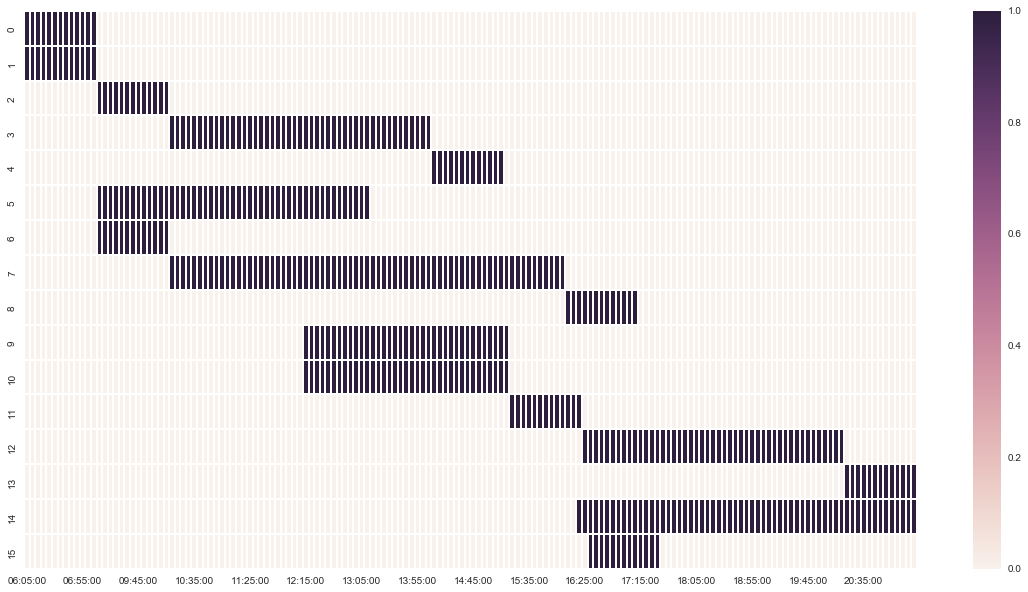

In [10]:
# Here we create the discrete time-buckets dataframe just like before ...
# ("Example-1") ...

# Create time-series between arrival of first plane and departure of last
time_series = pd.Series(True, index= pd.date_range(
        start=turns2.inbound_arrival.min(),
        end=turns2.outbound_departure.max(),
        freq=pd.offsets.Minute(min_bucket)))
    
# Truncate full time-series to [inbound_arrival, outbound_departure]
def trunc_ts(series):
    return time_series.truncate(series['inbound_arrival'], series['outbound_departure'])
    
heatmapdf = turns2.apply(trunc_ts, axis=1).T
    
# Convert columns from index to turn_no
heatmapdf.columns = turns2['turn_no'].get_values()
# Cast to integer
heatmapdf = heatmapdf.fillna(0).astype(int)
heatmapdf.index = heatmapdf.index.time

heatmapdf['tot'] = heatmapdf.sum(axis=1)
heatmapdf = heatmapdf[heatmapdf.tot > 1]
heatmapdf.drop(['tot'], axis=1, inplace=True)

# Plot the turns in the airport
sns.set()
plt.figure(figsize=(20, 10))

snsdf = heatmapdf.T
g = sns.heatmap(snsdf, rasterized=True, xticklabels=10, linewidths=1)

In [11]:
# We also set-up the model just before:
# 0. Initialise model
prob = LpProblem("Airport Gate Allocation", LpMinimize)  # minimize cost

# 1. Objective Function (ignore for now)
prob += 0

# 2. Variable: x[i,j] = (0,1)
# Binary = turn_i allocated to gate_j
x = {}
for t in turn_list:
    # For compatible gates
    for g in compatible_gates[t]:
        if g in occupancy.gate.get_values():
            
            t_dep = turns2.loc[turns2['turn_no']== t, 'outbound_departure'].values[0]
            t_arr = turns2.loc[turns2['turn_no']== t, 'inbound_arrival'].values[0]
            oc_from = occupancy.loc[occupancy['gate']== g, 'occupied_from'].values[0]
            oc_to = occupancy.loc[occupancy['gate']== g, 'occupied_to'].values[0]
            
            if (oc_to >= t_arr) and (oc_from <= t_dep):
                continue
                
        # Gate not occupied so create variable
        x[t, g] = LpVariable("t%i_g%s" % (t, g), 0, 1, LpBinary)

# 3. Constraints
# i. Each turn must be assigned to one compatible gate
for t in turn_list:
    prob += lpSum(x[t, g] for g in gate_list if (t, g) in x) == 1
    
# ii. Gates cannot have more than one turn/plane per time_bucket
for idx, row in heatmapdf.iterrows():
    # Get all the turns for time-bucket
    turns_in_time_bucket = set(dict(row[row==1]).keys())
    # For all gates
    for g in gate_list:
        # Constraints may be blank
        cons = [x[t, g] for t in turns_in_time_bucket if (t, g) in x]
        if len(cons) > 1:
            constraint_for_time_bucket = lpSum(cons) <= 1
            # These will occur when the plane overlaps change
            prob += constraint_for_time_bucket

In [12]:
w = {} # Create dictionary for tows
tow_turns = turns2[turns2.turn_part>0].turn_no.get_values() # List of potential tows

for tow_turn in tow_turns:
    w[tow_turn] = LpVariable("towing(%s)" % (tow_turn), 0, 1, LpBinary)
    
print(w)

{2: towing(2), 3: towing(3), 4: towing(4), 6: towing(6), 7: towing(7), 8: towing(8), 11: towing(11), 12: towing(12), 13: towing(13)}


In [13]:
# Remind ourselves of the turns ...
turns2[turns2.turn_part>0]

,original_turn,plane_size,from_country,to_country,inbound_arrival,outbound_departure,turn_part,turn_no
2,3,2,US,CZ,2016-02-01 09:10:00,2016-02-01 10:10:00,1.0,2
3,3,2,US,CZ,2016-02-01 10:15:00,2016-02-01 14:05:00,2.0,3
4,3,2,US,CZ,2016-02-01 14:10:00,2016-02-01 15:10:00,3.0,4
6,5,1,RU,FR,2016-02-01 09:10:00,2016-02-01 10:10:00,1.0,6
7,5,1,RU,FR,2016-02-01 10:15:00,2016-02-01 16:05:00,2.0,7
8,5,1,RU,FR,2016-02-01 16:10:00,2016-02-01 17:10:00,3.0,8
11,8,1,US,GB,2016-02-01 15:20:00,2016-02-01 16:20:00,1.0,11
12,8,1,US,GB,2016-02-01 16:25:00,2016-02-01 20:15:00,2.0,12
13,8,1,US,GB,2016-02-01 20:20:00,2016-02-01 21:20:00,3.0,13


In [14]:
# Map original turn to new turns (to group them)
tow_dic = {k: g["turn_no"].tolist() for k,g in turns2[turns2.turn_part>0].groupby("original_turn")}
print(tow_dic)  # Original turns 3, 5, 8 are eligible for towing

{8: [11, 12, 13], 3: [2, 3, 4], 5: [6, 7, 8]}


In [15]:
# Create tow-constraint
for k, v in tow_dic.items():
    print(k, v)
    for stand in gate_list:
        if ((v[0], stand) in x) and ((v[1], stand) in x):
            tow_out = x[v[0], stand] - x[v[1], stand] <= w[v[0]]
            prob += tow_out
        if ((v[1], stand) in x) and ((v[2], stand) in x):
            tow_in =  x[v[1], stand] - x[v[2], stand] <= w[v[1]]
            prob += tow_in

8 [11, 12, 13]
3 [2, 3, 4]
5 [6, 7, 8]


In [16]:
# Only part-2 can go to the 'rest-gates'
for t in turn_list:
    if turns2.loc[turns2['turn_no']== t, 'turn_part'].values[0] != 2:
        for stand in ["R1", "R2"]:
            prob += x[t, stand] == 0
    else:
        print(t)

3
7
12


In [17]:
# Add to objective with positive cost
# We should get no tows because they are costly and since no new turns are added we know
# ... the previous gates can handle them all
# If the cost is negative or 0 then tows can occur ...
pos_cost_coefficient = 100
tow_objective = lpSum(pos_cost_coefficient*w[t] for t in w)  
print(tow_objective)
prob += tow_objective

100*towing(11) + 100*towing(12) + 100*towing(13) + 100*towing(2) + 100*towing(3) + 100*towing(4) + 100*towing(6) + 100*towing(7) + 100*towing(8)


In [18]:
# Solve
prob.solve()

# Report
print("Status: ", LpStatus[prob.status])
print("Minimised Cost: ", value(prob.objective))

# Allocations
for alloc in x:
    if x[alloc].varValue:
        print("Turn %i assigned to gate %s" % (alloc[0], alloc[-1]))  

Status:  Optimal
Minimised Cost:  0.0
Turn 11 assigned to gate A2
Turn 5 assigned to gate A2
Turn 3 assigned to gate A3
Turn 6 assigned to gate C2
Turn 0 assigned to gate A3
Turn 14 assigned to gate C1
Turn 9 assigned to gate C1
Turn 2 assigned to gate A3
Turn 7 assigned to gate C2
Turn 1 assigned to gate B1
Turn 13 assigned to gate A2
Turn 4 assigned to gate A3
Turn 8 assigned to gate C2
Turn 15 assigned to gate A1
Turn 12 assigned to gate A2
Turn 10 assigned to gate B1


Given the cost associated with tows we should see none ... If we remove gates or add more turns then we will start to see turns to prevent infeasibility ...

In [19]:
for tow in w:
    print("Towing turn %i" % tow, bool(w[tow].varValue))

Towing turn 2 False
Towing turn 3 False
Towing turn 4 False
Towing turn 6 False
Towing turn 7 False
Towing turn 8 False
Towing turn 11 False
Towing turn 12 False
Towing turn 13 False


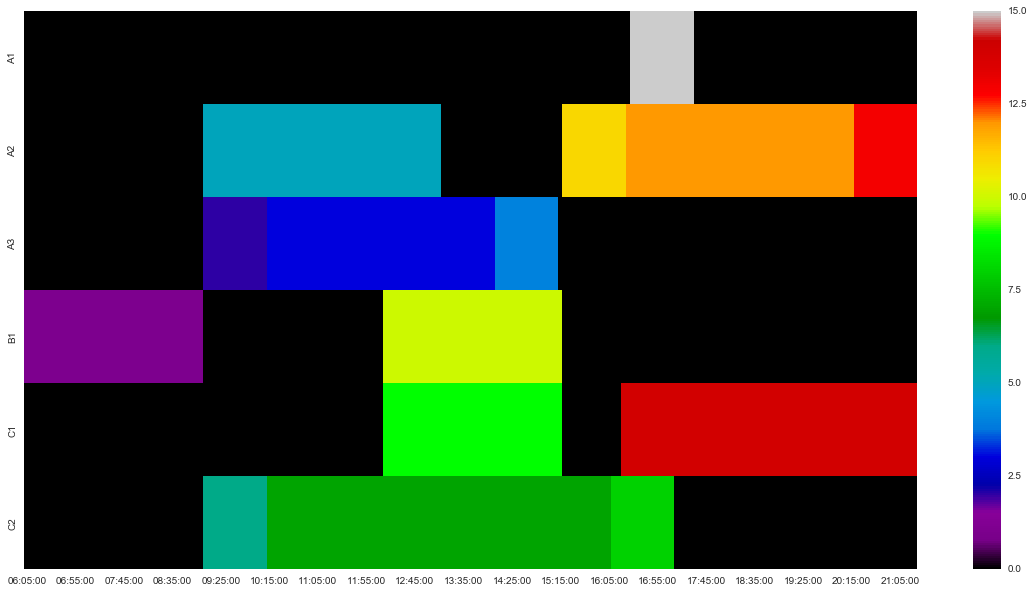

In [20]:
plot_gantt_chart(turns2, x)